# Import necessary components

In [29]:
import os
import math
import random
import torch
# import fires
import copy
import multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.cuda.amp import GradScaler
# import deepspeed
from datetime import datetime
from typing import Optional
from pprint import pprint, pformat
from torch.utils.data import DataLoader, IterableDataset
from timm.utils import ModelEmaV3
from timm.models import load_checkpoint
from timm.utils.model import unwrap_model, get_state_dict
try:
    from torch.utils.tensorboard import SummaryWriter
except ModuleNotFoundError:
    from tensorboardX import SummaryWriter

import sys

# sys.path.insert(0, "..")
sys.path.insert(0, ".")

In [30]:
from src.data import (
    collator,
    vocab_builder,
    tokenizer,
    read_dataset,
    OdpsTableIterableDataset,
)
from src.models import (
    GraphGPTConfig,
    GraphGPTCausal,
    GraphGPT2Config,
    GraphGPT2Causal,
    GraphBertConfig,
    GraphBertForMaskedLM,
)
from src.utils import (
    conf_utils,
    loss_utils,
    loader_utils,
    tokenizer_utils,
    modules_utils,
    misc_utils,
    print_trainable_parameters,
    print_params,
    inspect_tokenization_results,
    set_up_shuffle_and_sampler,
    worker_init_fn_seed,
)

dict_models = {
    "graphgpt2": (GraphGPT2Causal, GraphGPT2Config),
    "graphgpt": (GraphGPTCausal, GraphGPTConfig),
    "graphbert": (GraphBertForMaskedLM, GraphBertConfig),
}

# Define hyperparameters

In [31]:
data_dir: str = "../data/OGB"
tables: str = ""
# deepspeed_config = "./examples/ds_config2_pt.json"
intermediate_size = 0
num_attention_heads = 0
hidden_size = 512
num_hidden_layers = 8
task_type='pretrain'
causal_attention = 1
lr=3e-4
model_type = 'graphgpt'
output_dir='./exp/models/pcqm4m-v2/test'
pretrain_cpt = '/datalake/datastore1/yang/graph-gpt/exp/models/pcqm4m-v2/medium_ntp/pt_ns_h512_l8_b8192_mpe1024_tk1e9_gelu_pretrain3.3m_nmlm_mrlinear_mtp0.8_0_0.2_lr3e-4_adp0.1_pdp0_edp0_mdp0_lsi0_short_gated_wd0.1'
samples_per_saving=1000000

batch_size = 1024
stack_method = 'short'

pack_tokens = 0
max_position_embeddings = 1024

task_type='pretrain'
total_tokens=1e9
batch_size = 1024
warmup_tokens=1e8

In [32]:
use_tb_writer = False           # use tensorboard writer
use_ema = False # False # use exponential moving average to smooth model
use_deepspeed = False # True # use deepspeed for training, good to set scheduler
if (intermediate_size == 0) and (num_attention_heads == 0): # True
    (
        hidden_size,
        intermediate_size,
        num_attention_heads,
        num_hidden_layers,
    ) = modules_utils.set_up_model_architect(
        hidden_size=hidden_size, num_hidden_layers=num_hidden_layers # 768 24 related to model names intermediate_size = hidden_size * 4, num_attention_heads = hidden_size // 64
    )# 768 3072 12 24
causal_attention = 0 if task_type == "pretrain-mlm" else causal_attention
print('hidden_size:', hidden_size, 'intermediate_size:', intermediate_size, 'num_attention_heads:', num_attention_heads, 'num_hidden_layers:', num_hidden_layers, 'causal_attention:', causal_attention) # 768 3072 12 24 1


# #########################
# betas = (0.9, 0.95) # used in AdamW optimizer, important for config beta
# #########################
# # lr * 0.1 -> from llama2 pre-train settings
# min_lr = lr * 0.1 if use_deepspeed else 0    # used in scheduler, when not using deepspeed.
# #########################
gpu_name = torch.cuda.get_device_name()
GraphModel, GraphModelConfig = dict_models[model_type] # Not instantiate yet
print('gpu_name:', gpu_name, 'GraphModel:', GraphModel, 'GraphModelConfig:', GraphModelConfig) 

if os.path.exists(os.path.join(output_dir, "log.csv")):
    print(
        f"log file {os.path.join(output_dir, 'log.csv')} exists, resume training from {output_dir} instead of initializing from pre-train ckp {pretrain_cpt}!"
    )
    pretrain_cpt = output_dir


# # 0. init distributed train and get gpu/device info
# dist.init_process_group(backend="nccl", init_method="env://")  # for distributed training
# dist.barrier() # for sync training
# world_size = dist.get_world_size() # 1 # number of GPUs
# rank = dist.get_rank() # 0 # current GPU index
# local_rank = os.environ.get("LOCAL_RANK") # 0 # current GPU index local to the node
# print(f"\nworld size: {world_size}, rank: {rank}, local rank: {local_rank}") # 1 0 0
# rnd_seed = torch.random.initial_seed() - rank
# random.seed(rnd_seed)
# print(f"seed random with {rnd_seed}") # 1234
# steps_per_saving = samples_per_saving // (world_size * batch_size) # 1000000 // (1 * 1024) = 976
# print(f"\nsteps_per_saving: {steps_per_saving}") # 976
# params = print_params(**locals())

hidden_size: 512 intermediate_size: 2048 num_attention_heads: 8 num_hidden_layers: 8 causal_attention: 1
gpu_name: NVIDIA RTX A6000 GraphModel: <class 'src.models.graphgpt.modeling_graphgpt.GraphGPTCausal'> GraphModelConfig: <class 'src.models.graphgpt.configuration_graphgpt.GraphGPTConfig'>


# Load tokenizer config

In [33]:
# tokenizer config loading
import json

# Load the JSON file
file_path = "./zhang_test/tokenizer_config.json"
with open(file_path, "r") as json_file:
    tokenizer_config = json.load(json_file)

# Print the loaded data
# pprint(tokenizer_config)

In [34]:
# 1.1 read configuration
assert "pretrain" in tokenizer_config["task_type"]
assert (
    tokenizer_config["semantics"]["attr_assignment"]   # first
    in tokenizer_utils.ATTR_ASSIGNMENT_TYPES   # ATTR_ASSIGNMENT_TYPES = {"first", "last", "random", "all", "mix"}
)
# pprint(tokenizer_config)
if tokenizer_config["tokenizer_class"] == "StackedGSTTokenizer":
    attr_dim = (
        tokenizer_config["semantics"]["edge"]["dim"] # 3
        + tokenizer_config["semantics"]["node"]["dim"] # 9
    ) # 12
    assert stack_method in ("short", "long", None), f"stack_method: {stack_method}" # short
    if tokenizer_config["structure"]["edge"]["remove_edge_type_token"]: # True
        stacked_feat = 1 + attr_dim
    else:
        stacked_feat = 2 + attr_dim
    next_n_token = stacked_feat
else:
    stacked_feat = 1
    next_n_token = 1 # maybe how many pack of tokens to predict
embed_dim = tokenizer_config["semantics"]["node"].get(
    "embed_dim", 0
) + tokenizer_config["semantics"]["edge"].get("embed_dim", 0) # 0
print(
    f"stacked_feat: {stacked_feat}, next_n_token: {next_n_token}, embed_dim: {embed_dim}" # 13 13 0
)

stacked_feat: 13, next_n_token: 13, embed_dim: 0


# Load dataset

In [35]:
# 1.2 get graph dataset
train_dataset, valid_dataset, test_dataset, raw_dataset = read_dataset(
    name=tokenizer_config["dataset"],   # PCQM4Mv2
    # for local data file reading
    data_dir=data_dir,   # './data/OGB'
    sampling_config=tokenizer_config["sampling"],    # None
    # for odps data reading
    table=tables,   # ""
    edge_dim=tokenizer_config["semantics"]["edge"]["dim"],    # 3
    node_dim=tokenizer_config["semantics"]["node"]["dim"],    # 9
    mode="train",
    # general
    # pretrain_mode=True,
    return_valid_test=True,
    ensemble_datasets=tokenizer_config.get("ensemble_datasets", []),    # []
)
reset_samples_per_epoch = (   # what is this  # None for PCQM4Mv2
    test_dataset.reset_samples_per_epoch
    if hasattr(test_dataset, "reset_samples_per_epoch")
    else False
)
if isinstance(test_dataset, IterableDataset):
    print(next(iter(test_dataset))) 
else: # True
    idx = test_dataset.sampler[0] # (0, Data(edge_index=[2, 40], edge_attr=[40, 3], x=[18, 9], y=[1, 1], num_nodes=18, idx=0, idx_of_ds=0))
    print(test_dataset[idx])


Loading dataset PCQM4Mv2 ...

dataset._data -> Data(edge_index=[2, 109093626], edge_attr=[109093626, 3], x=[52970652, 9], y=[3746620])

Raw indices: 3378606, Removed indices: 0, New indices: 3378606

Raw indices: 73545, Removed indices: 0, New indices: 73545
Using all valid data as valid: 73545, and last half of valid data as test: 36773!
[Warning] permute_nodes enabled! edge_attr remains the same; edge_index and node-attrs will be affected!
[Warning] permute_nodes enabled! edge_attr remains the same; edge_index and node-attrs will be affected!
[Warning] permute_nodes enabled! edge_attr remains the same; edge_index and node-attrs will be affected!
[Warning] permute_nodes enabled! edge_attr remains the same; edge_index and node-attrs will be affected!
[Warning] permute_nodes enabled! edge_attr remains the same; edge_index and node-attrs will be affected!

[2025-05-16 17:50:18.053363] NOT RESET samples of GraphsMapDataset of 3378606 graphs for epoch None!
idx_tuple: None
[Warning] permu

# Build vocabulary

In [36]:
add_eos = False
rank = 0
stack_method = "short"
# 1.3 build vocab and then init tokenizer from the tokenization config
tokenizer_cls = getattr(tokenizer, tokenizer_config["tokenizer_class"]) # StackGSTTokenizer, custom defined
gtokenizer = tokenizer_cls(
    tokenizer_config, add_eos=add_eos, stack_method=stack_method # instantiate
)

[2025-05-16 17:50:18.530703] Loading vocab from ./data/OGB/pcqm4m-v2/vocab512_stacked ...
[2025-05-16 17:50:18.572672]
{   '0': 22,
    '1': 23,
    '10': 32,
    '100': 122,
    '101': 123,
    '102': 124,
    '103': 125,
    '104': 126,
    '105': 127,
    '106': 128,
    '107': 129,
    '108': 130,
    '109': 131,
    '11': 33,
    '110': 132,
    '111': 133,
    '112': 134,
    '113': 135,
    '114': 136,
    '115': 137,
    '116': 138,
    '117': 139,
    '118': 140,
    '119': 141,
    '12': 34,
    '120': 142,
    '121': 143,
    '122': 144,
    '123': 145,
    '124': 146,
    '125': 147,
    '126': 148,
    '127': 149,
    '128': 150,
    '129': 151,
    '13': 35,
    '130': 152,
    '131': 153,
    '132': 154,
    '133': 155,
    '134': 156,
    '135': 157,
    '136': 158,
    '137': 159,
    '138': 160,
    '139': 161,
    '14': 36,
    '140': 162,
    '141': 163,
    '142': 164,
    '143': 165,
    '144': 166,
    '145': 167,
    '146': 168,
    '147': 169,
    '148': 170,
 

# Set model

In [37]:
import pickle
with open("./zhang_test/model_config.pkl", "rb") as file:  # "rb" mode for reading binary
    config = pickle.load(file)
# print(config)

In [38]:
model = GraphModel(config)


# model.gradient_checkpointing_enable()
# silence the warnings. Please re-enable for inference!
model.config.use_cache = False
print_trainable_parameters(model) # 235368960

NOT Applying dropout in backbone transformer
Next-token-prediction changed to next/masked-13-tokens-prediction!
trainable params: 37751808 || all params: 37751808 || trainable%: 100.0


In [39]:

# 2.21 load from ckp IF provided existing ckp and NOT resume from the ckp
ckp, _ = misc_utils.get_latest_ckp(pretrain_cpt)
print(f"Loading pretrained weights from ckp {ckp}")
try:
    # fn_model = os.path.join(ckp, "../model_ema_best.pt")
    # if not os.path.isfile(fn_model):
    fn_model = os.path.join(ckp, "model.pt")
    stat_dict = torch.load(fn_model)
    stat_dict = {
        (k[7:] if k.startswith("module.") else k): v for k, v in stat_dict.items()
    }
    print(f"[{datetime.now()}] load ckp using torch API from:\n{fn_model}")
except Exception as inst:
    # print(type(inst))
    # print(inst.args)
    print("inar: ", inst)
    from deepspeed.utils.zero_to_fp32 import (
        get_fp32_state_dict_from_zero_checkpoint,
    )
    stat_dict = get_fp32_state_dict_from_zero_checkpoint(ckp)
    print(
        f"[{datetime.now()}] load ckp using DeepSpeed API `get_fp32_state_dict_from_zero_checkpoint`"
    )

for key in list(stat_dict.keys()):
    if ("score" in key) and skip_keys:
        stat_dict.pop(key)
        print(f"pop key {key} in stat_dict!")
missing_keys, unexpected_keys = model.load_state_dict(stat_dict, strict=True)
print(
    f"[{datetime.now()}] init model params using pytorch `load_state_dict`\n"
    f"missing keys: {missing_keys}\n"
    f"unexpected_keys: {unexpected_keys}\n"
    f"After loading weights from ckp:\n{model.config}\nmodel-type: {model.dtype}\n\n{model}"
)

Loading pretrained weights from ckp /datalake/datastore1/yang/graph-gpt/exp/models/pcqm4m-v2/medium_ntp/pt_ns_h512_l8_b8192_mpe1024_tk1e9_gelu_pretrain3.3m_nmlm_mrlinear_mtp0.8_0_0.2_lr3e-4_adp0.1_pdp0_edp0_mdp0_lsi0_short_gated_wd0.1/epoch_51
inar:  [Errno 2] No such file or directory: '/datalake/datastore1/yang/graph-gpt/exp/models/pcqm4m-v2/medium_ntp/pt_ns_h512_l8_b8192_mpe1024_tk1e9_gelu_pretrain3.3m_nmlm_mrlinear_mtp0.8_0_0.2_lr3e-4_adp0.1_pdp0_edp0_mdp0_lsi0_short_gated_wd0.1/epoch_51/model.pt'
Processing zero checkpoint '/datalake/datastore1/yang/graph-gpt/exp/models/pcqm4m-v2/medium_ntp/pt_ns_h512_l8_b8192_mpe1024_tk1e9_gelu_pretrain3.3m_nmlm_mrlinear_mtp0.8_0_0.2_lr3e-4_adp0.1_pdp0_edp0_mdp0_lsi0_short_gated_wd0.1/epoch_51/global_step48830'
Detected checkpoint of type zero stage 2, world_size: 1
Parsing checkpoint created by deepspeed==0.15.1
Reconstructed fp32 state dict with 77 params 37751808 elements
[2025-05-16 17:50:20.186330] load ckp using DeepSpeed API `get_fp32_stat

# Generation

In [40]:
from src.utils.my_utiles import graph2token2input_generation
from src.utils.my_utiles import graph2smiles
import numpy as np
from src.utils.my_utiles import convert_to_tensors

# smiles = "CCO" # "CC(=O)OC1=CC=CC=C1C(=O)O"\
random_index = np.random.randint(0, len(test_dataset))  # Upper bound is exclusive
print(random_index)
random_index = 0
graph = test_dataset[random_index][1]
# graph = graph_to_torch_geometric(graph)
smiles2 = graph2smiles(graph.edge_index, graph.edge_attr, graph.x)
example_graph = graph
print(smiles2)

num_input, max_length = 2, 40 # We use the first 2 nodes as input
token, label, embed, inputs = graph2token2input_generation(graph, gtokenizer, num_input, max_length)

25810
Cc1ccc(C2Cc3cnccc3NC2=O)cc1
Inspecting tokenization results!
Tokenize graph:
Data(edge_index=[2, 40], edge_attr=[40, 3], x=[18, 9], y=[1], num_nodes=18, idx=0, idx_of_ds=0)
[Warning] Set eos_idx to 100000000 for task pretrain!


In [41]:
tensor_inputs = convert_to_tensors(inputs)

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GraphGPTCausal(
  (model): LlamaModel(
    (embed_tokens): Embedding(756, 512, padding_idx=0)
    (layers): ModuleList(
      (0-7): 8 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=512, out_features=512, bias=False)
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=False)
          (o_proj): Linear(in_features=512, out_features=512, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=512, out_features=2048, bias=False)
          (up_proj): Linear(in_features=512, out_features=2048, bias=False)
          (down_proj): Linear(in_features=2048, out_features=512, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_he

In [43]:
model.eval()
generated = model.generate_packed(
    input_ids=tensor_inputs["input_ids"].to(device),
    attention_mask=tensor_inputs["attention_mask"].to(device),
    max_new_tokens = 30,
    temperature = 1,
    top_k = 50,
    eos_token_id = 19,
    pad_token_id = 0,
    entire_context = True,
)


In [44]:
generated

tensor([[[ 48, 630, 685, 695, 709, 714, 724, 731, 737, 739, 740, 741, 742],
         [ 49, 630, 687, 696, 709, 715, 724, 732, 736, 739, 743, 748, 754],
         [ 50, 630, 685, 696, 709, 715, 724, 731, 736, 738, 743, 748, 754],
         [ 51, 630, 685, 696, 709, 717, 724, 732, 736, 738, 743, 748, 754],
         [ 50, 630, 685, 696, 709, 715, 724, 732, 736, 738, 743, 748, 754],
         [ 52, 630, 685, 696, 709, 717, 724, 732, 736, 738, 743, 748, 754],
         [ 50, 630, 685, 696, 709, 715, 724, 732, 736, 738, 743, 748, 754],
         [ 49, 630, 687, 696, 709, 715, 724, 732, 736, 739, 743, 748, 754],
         [ 53, 630, 685, 695, 709, 714, 724, 732, 736, 739, 743, 748, 754],
         [ 54, 630, 685, 696, 709, 717, 724, 731, 736, 738, 743, 748, 755],
         [ 53, 630, 685, 695, 709, 714, 724, 731, 736, 739, 743, 748, 755],
         [ 55, 630, 685, 694, 709, 715, 724, 731, 736, 739, 744, 748, 755],
         [ 56, 630, 685, 695, 709, 715, 724, 731, 736, 739, 744, 748, 755],
         [ 5

In [45]:
tensor_inputs["labels"]

tensor([[[ 49, 630, 687, 696, 709, 715, 724, 732, 736, 739, 743, 748, 754],
         [ 50, 630, 685, 695, 709, 714, 724, 731, 736, 739, 743, 748, 754],
         [ 51, 652, 685, 691, 709, 714, 724, 731, 736, 738, 744, 748, 755],
         [ 50, 630, 685, 695, 709, 714, 724, 731, 736, 739, 744, 748, 755],
         [ 52, 641, 685, 694, 709, 714, 725, 731, 736, 739, 743, 748, 755],
         [ 53, 630, 685, 695, 709, 714, 724, 731, 737, 739, 743, 748, 755],
         [ 54, 630, 685, 695, 709, 714, 724, 731, 737, 739, 746, 748, 755],
         [ 55, 630, 685, 695, 709, 715, 724, 731, 737, 739, 746, 748, 755],
         [ 56, 641, 685, 694, 709, 714, 724, 731, 737, 739, 746, 748, 755],
         [ 57, 630, 685, 695, 709, 715, 724, 731, 737, 739, 746, 748, 755],
         [ 58, 630, 685, 695, 709, 715, 724, 731, 737, 739, 746, 748, 755],
         [ 53, 630, 685, 695, 709, 714, 724, 731, 737, 739, 746, 748, 755],
         [ 54, 630, 685, 695, 709, 714, 724, 731, 737, 739, 746, 748, 755],
         [ 5

In [46]:
tensor_inputs["labels"].shape

torch.Size([1, 25, 13])

In [47]:
from src.utils.my_utiles import remove_zero_rows
generated = remove_zero_rows(generated)
print(generated)
print(generated.shape)

tensor([[[ 48, 630, 685, 695, 709, 714, 724, 731, 737, 739, 740, 741, 742],
         [ 49, 630, 687, 696, 709, 715, 724, 732, 736, 739, 743, 748, 754],
         [ 50, 630, 685, 696, 709, 715, 724, 731, 736, 738, 743, 748, 754],
         [ 51, 630, 685, 696, 709, 717, 724, 732, 736, 738, 743, 748, 754],
         [ 50, 630, 685, 696, 709, 715, 724, 732, 736, 738, 743, 748, 754],
         [ 52, 630, 685, 696, 709, 717, 724, 732, 736, 738, 743, 748, 754],
         [ 50, 630, 685, 696, 709, 715, 724, 732, 736, 738, 743, 748, 754],
         [ 49, 630, 687, 696, 709, 715, 724, 732, 736, 739, 743, 748, 754],
         [ 53, 630, 685, 695, 709, 714, 724, 732, 736, 739, 743, 748, 754],
         [ 54, 630, 685, 696, 709, 717, 724, 731, 736, 738, 743, 748, 755],
         [ 53, 630, 685, 695, 709, 714, 724, 731, 736, 739, 743, 748, 755],
         [ 55, 630, 685, 694, 709, 715, 724, 731, 736, 739, 744, 748, 755],
         [ 56, 630, 685, 695, 709, 715, 724, 731, 736, 739, 744, 748, 755],
         [ 5

In [48]:
generated.shape

torch.Size([1, 23, 13])

In [49]:
# File path to your vocabulary file
vocab_file_path = "/datalake/datastore1/yang/graph-gpt/data/OGB/pcqm4m-v2/vocab512_stacked"

from src.utils.my_utiles import load_vocab

vocab = load_vocab(vocab_file_path)

from src.utils.my_utiles import convert_labels_to_tokens
# Example usage
# Assuming `reshaped_labels` contains the predicted label IDs of shape [1, 24, 13]
tokens = convert_labels_to_tokens(generated, vocab)
print("tokens.shape:", np.array(tokens).shape)
# Optional: Reshape tokens back to the original structure for visualization
# tokens_reshaped = [
#     [tokens[i * 13 + j] for j in range(13)] for i in range(tensor_inputs["labels"].shape[1])
# ]
tokens_reshaped = [
    [tokens[i * 13 + j] for j in range(13)] for i in range(generated.shape[1])
]
print(generated.shape)
# Print tokens
print(np.array(tokens_reshaped).shape)
pprint(tokens_reshaped)


tokens.shape: (299,)
torch.Size([1, 23, 13])
(23, 13)
[['26',
  'molecule#node#0#5',
  'molecule#node#1#0',
  'molecule#node#2#3',
  'molecule#node#3#5',
  'molecule#node#4#0',
  'molecule#node#5#0',
  'molecule#node#6#1',
  'molecule#node#7#1',
  'molecule#node#8#1',
  'molecule#edge#0',
  'molecule#edge#1',
  'molecule#edge#2'],
 ['27',
  'molecule#node#0#5',
  'molecule#node#1#2',
  'molecule#node#2#4',
  'molecule#node#3#5',
  'molecule#node#4#1',
  'molecule#node#5#0',
  'molecule#node#6#2',
  'molecule#node#7#0',
  'molecule#node#8#1',
  'molecule#edge#0#0',
  'molecule#edge#1#0',
  'molecule#edge#2#0'],
 ['28',
  'molecule#node#0#5',
  'molecule#node#1#0',
  'molecule#node#2#4',
  'molecule#node#3#5',
  'molecule#node#4#1',
  'molecule#node#5#0',
  'molecule#node#6#1',
  'molecule#node#7#0',
  'molecule#node#8#0',
  'molecule#edge#0#0',
  'molecule#edge#1#0',
  'molecule#edge#2#0'],
 ['29',
  'molecule#node#0#5',
  'molecule#node#1#0',
  'molecule#node#2#4',
  'molecule#node#3#5

In [50]:
tokens_reshaped = tokens_reshaped[:-1]
print(np.array(tokens_reshaped).shape)

(22, 13)


In [51]:
from src.utils.my_utiles import token_to_graph 
graph_x, graph_edge_index, graph_edge_attr = token_to_graph(tokens_reshaped)

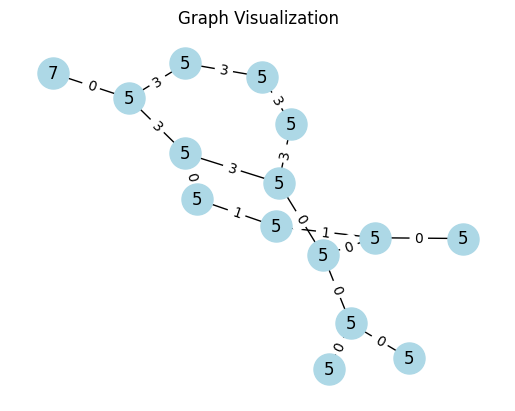

In [52]:
from src.utils.my_utiles import plot_graph
plot_graph(graph_x, graph_edge_index, graph_edge_attr)

In [53]:
# smiles = graph2smiles(graph_edge_index, graph_edge_attr, graph_x)
# print("SMILES:", smiles)

# Iterative generation till valid molecules

Attempt 1/10 failed: invalid literal for int() with base 10: '<eos>'
Attempt 2/10 failed: invalid literal for int() with base 10: '<eos>'
Attempt 3/10 failed: invalid literal for int() with base 10: '<eos>'


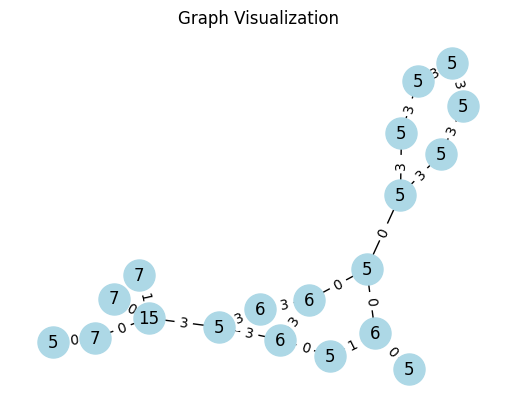

[17:50:35] Explicit valence for atom # 2 N, 4, is greater than permitted


Attempt 4/10 failed: Explicit valence for atom # 2 N, 4, is greater than permitted
Attempt 5/10 failed: invalid literal for int() with base 10: '<eos>'


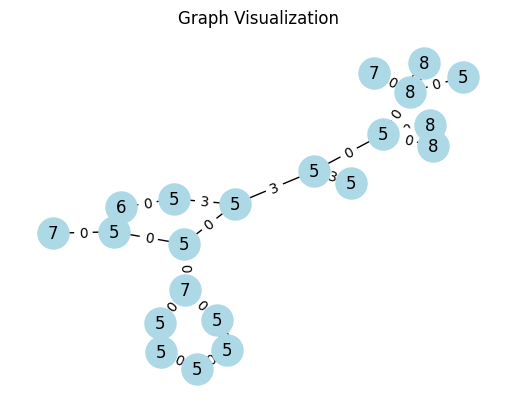

[17:50:35] Explicit valence for atom # 2 O, 3, is greater than permitted


Attempt 6/10 failed: Explicit valence for atom # 2 O, 3, is greater than permitted


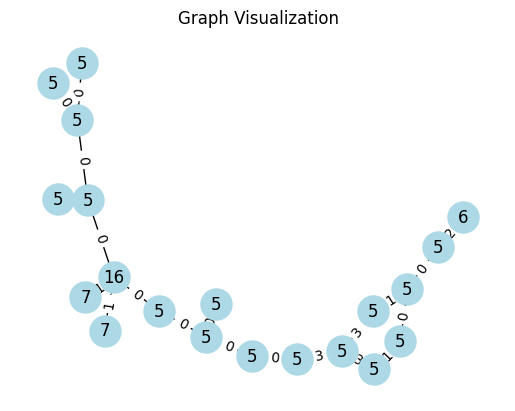

[17:50:36] Explicit valence for atom # 3 Cl, 6, is greater than permitted


Attempt 7/10 failed: Explicit valence for atom # 3 Cl, 6, is greater than permitted


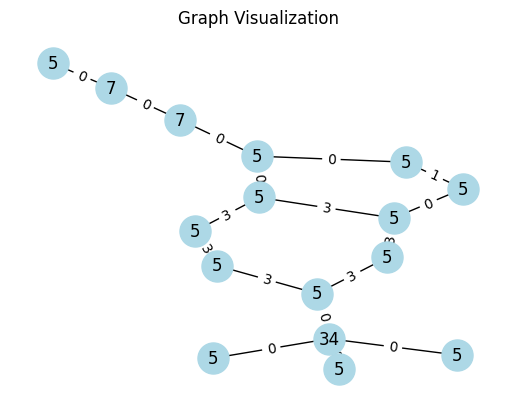

[17:50:36] Explicit valence for atom # 10 Br, 4, is greater than permitted


Attempt 8/10 failed: Explicit valence for atom # 10 Br, 4, is greater than permitted


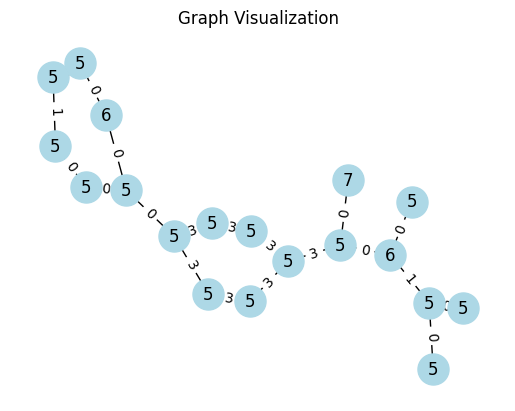

[17:50:37] Explicit valence for atom # 12 N, 4, is greater than permitted


Attempt 9/10 failed: Explicit valence for atom # 12 N, 4, is greater than permitted


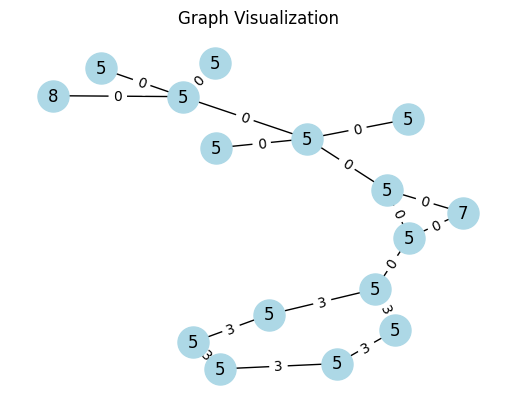

Generated SMILES: CC(C)(F)C(C)(C)C1OC1c1ccccc1 in 10 attempt(s)


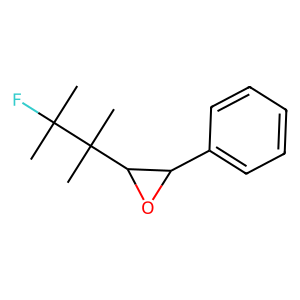

In [56]:
import numpy as np
from src.utils.my_utiles import remove_zero_rows, load_vocab, convert_labels_to_tokens, token_to_graph

# File path to your vocabulary file
VOCAB_FILE_PATH = "/datalake/datastore1/yang/graph-gpt/data/OGB/pcqm4m-v2/vocab512_stacked"

# Load the vocabulary
vocab = load_vocab(VOCAB_FILE_PATH)

def generate_valid_molecule(model, tensor_inputs, device, max_retries=10):
    """
    Generates a valid molecule by retrying until `graph2smiles` succeeds or max retries are reached.

    Parameters:
        model: The model to generate predictions.
        tensor_inputs: Dictionary containing input tensors such as 'input_ids' and 'attention_mask'.
        device: The device (CPU/GPU) to use for computation.
        max_retries: Maximum number of attempts to generate a valid molecule.

    Returns:
        smiles (str): The valid SMILES string of the molecule.
        retries (int): Number of attempts made to generate a valid molecule.
    """
    for attempt in range(max_retries):
        try:
            # Set model to evaluation mode
            model.eval()

            # Generate predictions
            generated = model.generate_packed(
                input_ids=tensor_inputs["input_ids"].to(device),
                attention_mask=tensor_inputs["attention_mask"].to(device),
                max_new_tokens=30,
                temperature=1,
                top_k=50,
                eos_token_id=19,
                pad_token_id=0,
                entire_context=True,
            )

            # Remove zero rows from generated output
            generated = remove_zero_rows(generated)

            # Convert labels to tokens
            tokens = convert_labels_to_tokens(generated, vocab)

            # Reshape tokens
            tokens_reshaped = [
                [tokens[i * 13 + j] for j in range(13)] for i in range(generated.shape[1])
            ]

            # Exclude the last token sequence if necessary
            # print(tokens_reshaped)
            # print(np.array(tokens_reshaped).shape)
            if tokens_reshaped[-1][-1] == '<eos>':
                tokens_reshaped = tokens_reshaped[:-1]

            # Convert tokens to graph representation
            graph_x, graph_edge_index, graph_edge_attr = token_to_graph(tokens_reshaped)
            plot_graph(graph_x, graph_edge_index, graph_edge_attr)
            # Convert graph to SMILES
            smiles = graph2smiles(graph_edge_index, graph_edge_attr, graph_x)

            # If successful, return the SMILES string and attempt count
            return smiles, attempt + 1

        except Exception as e:
            print(f"Attempt {attempt + 1}/{max_retries} failed: {e}")

    # If all attempts fail, raise an exception
    raise ValueError(f"Failed to generate a valid molecule after {max_retries} attempts.")

# Example usage
smiles, retries = generate_valid_molecule(model, tensor_inputs, device)
print(f"Generated SMILES: {smiles} in {retries} attempt(s)")

from rdkit import Chem
from rdkit.Chem import Draw

# Convert the SMILES string to a molecule object
molecule = Chem.MolFromSmiles(smiles)

# Draw the molecule
Draw.MolToImage(molecule)